# **PSD UTS "Prediksi Produksi Penjualan Ice Cream"** 



*   Nama : Zulfa Lailatul Mu'achirin
*   Nim : 220411100147
*   Matkul : PSD D

## Data Understanding

Data diperoleh dari kaggle https://www.kaggle.com/datasets/atharvaarya25/ice-cream-production-over-50-years. Pada data tersebut hanya terdapat 2 fitur yaitu DATE yang menunjukkan tanggal dan IPN31152N yang merupakan fitur produksi penjualan. Pada data ini terdapat 577 data yang dikumpulkan dari 48 tahun terakhir mulai dari tahun 1972 sampai tahun 2020. Data yang dikumpulkan merupakan data yang diambil setiap bulan pada tanggal 1 untuk produksi penjualan.

prediksi ini berguna untuk :

1.   perencanaan produksi stok
2.   melihat pola permintaan musiman
3.   pengambilan keputusan bisnis



### library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor # Import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler # Import StandardScaler for scaling
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import VotingRegressor

### menampilkan data

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/kuliah sem 5/PSD/Mydata/ice_cream.xlsx")
df['DATE'] = pd.to_datetime(df['DATE'])

df

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636
...,...,...
572,2019-09-01,100.1741
573,2019-10-01,90.1684
574,2019-11-01,79.7223
575,2019-12-01,75.7094


## Data Preprocessing

Untuk menerapkan pembelajaran supervised pada peramalan time series , kita perlu mengubah data time series ke dalam format yang sesuai. Hal ini melibatkan pembuatan pasangan input-output dari data berurutan menggunakan teknik sliding window.

### missing value

mengecek apakah ada missing value pada data yang dipakai

In [ ]:
missing_values = df.isnull().sum()
print(missing_values)

DATE         0
IPN31152N    0
dtype: int64


### deskripsi data

In [ ]:
description = df.describe()
print(description)

                                DATE   IPN31152N
count                            577  577.000000
mean   1995-12-31 16:15:48.353552896  109.701844
min              1972-01-01 00:00:00   58.659800
25%              1984-01-01 00:00:00   88.514900
50%              1996-01-01 00:00:00  107.461700
75%              2008-01-01 00:00:00  127.932300
max              2020-01-01 00:00:00  196.173700
std                              NaN   27.951723


### Visualisasi data dan outlier

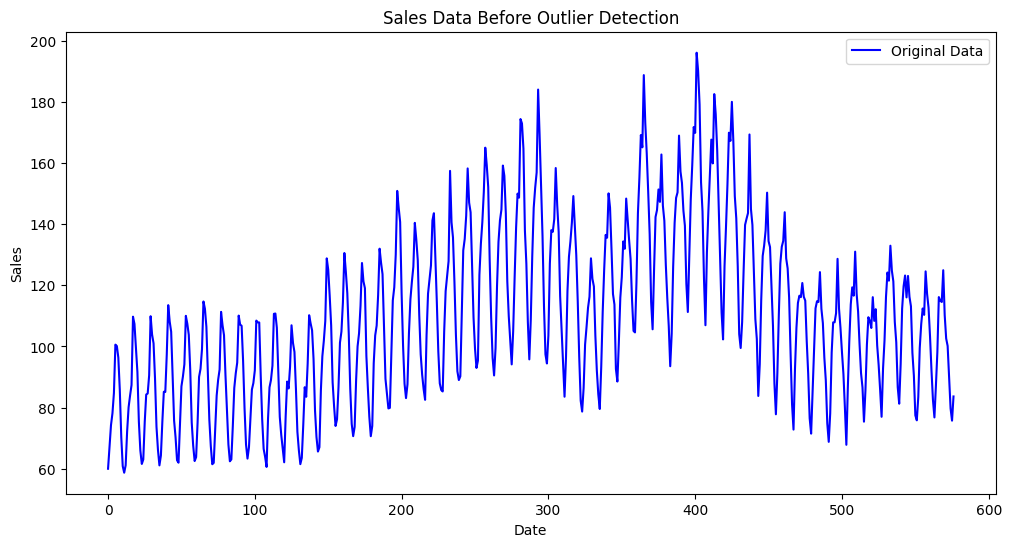

Number of Outliers Detected: 3


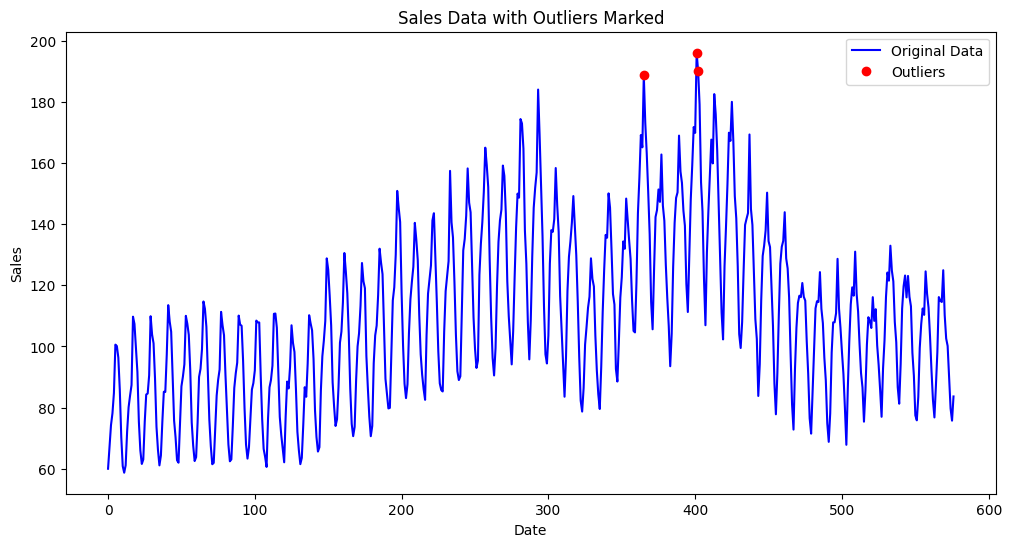

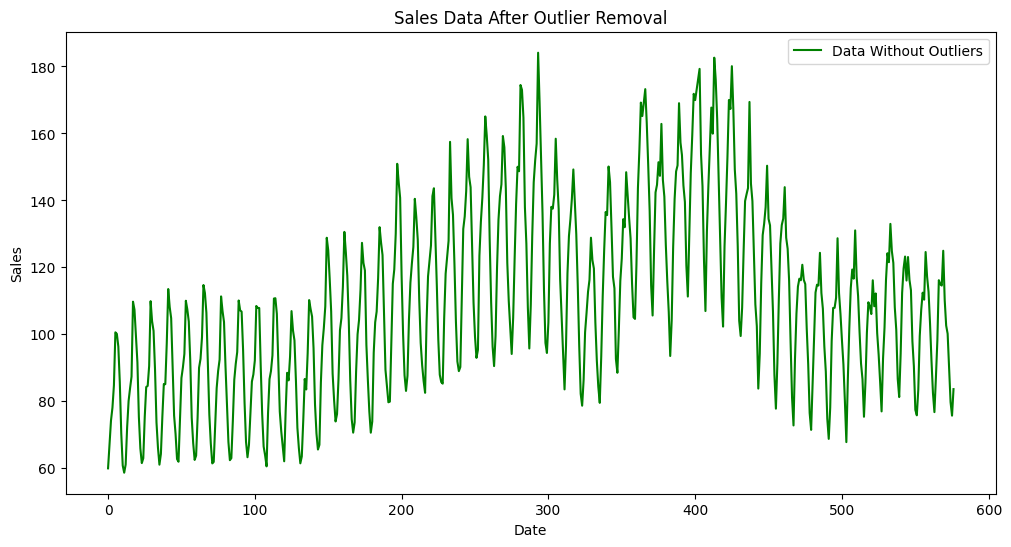

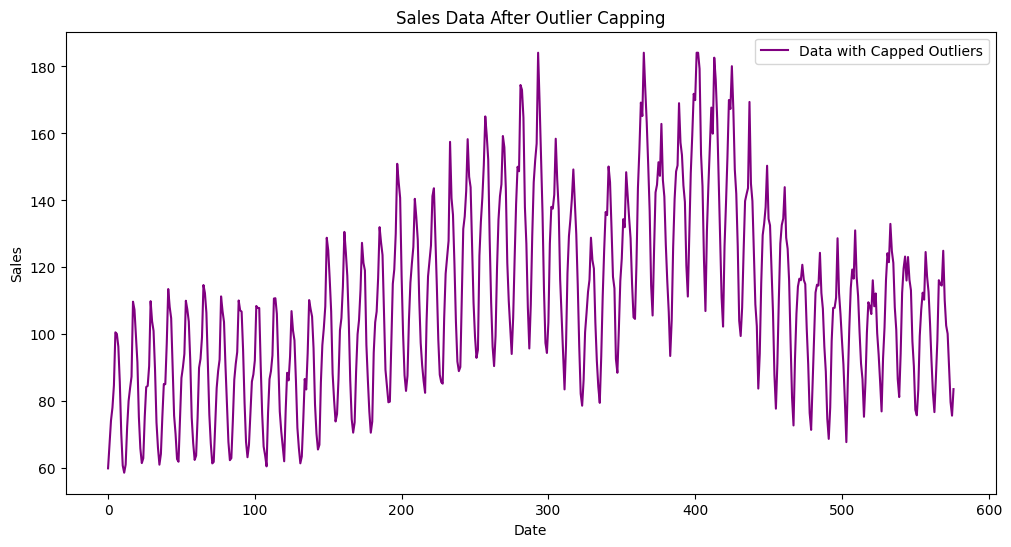

In [ ]:
# Visualize the original data to see the distribution
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['IPN31152N'], label='Original Data', color='blue')
plt.title("Sales Data Before Outlier Detection")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

# Method 1: Detecting outliers using IQR (Interquartile Range)
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    # Define outliers as values outside 1.5 * IQR from the Q1 and Q3 bounds
    outliers = (data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))
    return outliers

# Detect outliers in 'IPN31152N' using IQR method
outliers = detect_outliers_iqr(df['IPN31152N'])
print("Number of Outliers Detected:", outliers.sum())

# Visualize data with outliers marked
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['IPN31152N'], label='Original Data', color='blue')
plt.plot(df.index[outliers], df['IPN31152N'][outliers], 'ro', label='Outliers')
plt.title("Sales Data with Outliers Marked")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

# Handle Outliers: Remove or cap them (choose the approach that suits your analysis)
# Option 1: Remove Outliers
df_no_outliers = df[~outliers]

# Option 2: Cap Outliers to a certain threshold (example: max within Q3 + 1.5*IQR)
capped_data = df['IPN31152N'].copy()
capped_data[outliers] = df['IPN31152N'][~outliers].max()  # Capping outliers to the max non-outlier value
df_capped = df.copy()
df_capped['IPN31152N'] = capped_data

# Visualize the data after outlier removal
plt.figure(figsize=(12, 6))
plt.plot(df_no_outliers.index, df_no_outliers['IPN31152N'], label='Data Without Outliers', color='green')
plt.title("Sales Data After Outlier Removal")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

# Visualize the data after capping outliers
plt.figure(figsize=(12, 6))
plt.plot(df_capped.index, df_capped['IPN31152N'], label='Data with Capped Outliers', color='purple')
plt.title("Sales Data After Outlier Capping")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


## Modeling

### membagi data

Untuk fiturnya kita memakai fitur month serta untuk targetnya kita memakai fitur IPN31152N, kemudian dengan teknik sliding window untuk mengenerate fitur berdasarkan bulan sebelumnya. Untuk window_size nya sendiri adalah 12, karena kita akan memakai 12 bulan untuk prediksi 12 bulan kedepan

Metode jendela geser melibatkan penggunaan jendela berukuran tetap dari langkah waktu sebelumnya untuk memprediksi langkah waktu berikutnya. Metode ini juga dikenal sebagai data tertinggal(lagged data).

In [ ]:
# Assuming 'DATE' is the date column and 'IPN31152N' is the target variable
df = df.sort_values('DATE').set_index('DATE')

# Define the target variable 'y'
y = df['IPN31152N'].values

# Function to create sliding window features based on the date index, without an explicit 'Month' feature
def create_sliding_window_features(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])  # Collect previous 'window_size' values
        y.append(data[i])  # Current target value
    return np.array(X), np.array(y)

# Set the window size to 12 (or any desired number of months/periods)
window_size = 12

# Generate the sliding window features and target
X_window, y_window = create_sliding_window_features(y, window_size)

print("Shape of X_window:", X_window.shape)
print("Shape of y_window:", y_window.shape)

Shape of X_window: (565, 12)
Shape of y_window: (565,)


Kalau ingin dilihat hasil dari X_window dan y_window

In [ ]:
# Define column names generically for previous periods without 'Month' labels
columns = [f'Prev-{i}' for i in range(window_size, 0, -1)]  # Names for each previous period in the window

# Create dataframe for sliding window features and target
df_window = pd.DataFrame(X_window, columns=columns)  # Sliding window features
df_window['Target'] = y_window  # Target column

# Display the resulting dataframe
df_window


,Prev-12,Prev-11,Prev-10,Prev-9,Prev-8,Prev-7,Prev-6,Prev-5,Prev-4,Prev-3,Prev-2,Prev-1,Target
0,59.9622,67.0605,74.2350,78.1120,84.7636,100.5960,100.1263,96.3607,85.8007,70.3934,60.8072,58.6598,61.0996
1,67.0605,74.2350,78.1120,84.7636,100.5960,100.1263,96.3607,85.8007,70.3934,60.8072,58.6598,61.0996,72.2062
2,74.2350,78.1120,84.7636,100.5960,100.1263,96.3607,85.8007,70.3934,60.8072,58.6598,61.0996,72.2062,80.0984
3,78.1120,84.7636,100.5960,100.1263,96.3607,85.8007,70.3934,60.8072,58.6598,61.0996,72.2062,80.0984,83.9059
4,84.7636,100.5960,100.1263,96.3607,85.8007,70.3934,60.8072,58.6598,61.0996,72.2062,80.0984,83.9059,87.3712
...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,103.3118,92.1321,82.4347,76.7608,86.9988,98.1116,116.1718,114.9703,114.5613,124.9605,110.2632,102.6085,100.1741
561,92.1321,82.4347,76.7608,86.9988,98.1116,116.1718,114.9703,114.5613,124.9605,110.2632,102.6085,100.1741,90.1684
562,82.4347,76.7608,86.9988,98.1116,116.1718,114.9703,114.5613,124.9605,110.2632,102.6085,100.1741,90.1684,79.7223
563,76.7608,86.9988,98.1116,116.1718,114.9703,114.5613,124.9605,110.2632,102.6085,100.1741,90.1684,79.7223,75.7094


dari array hasil pada pembuatan fitur dengan sliding window kita akan membagi datanya untuk dijadikan data train dan data test. Dengan data train 80% dan data test 20% tanpa diacak, guna mempertahankan urutan waktunya. Kemudian kita normalisasi dengan standarscaler.

Kode ini digunakan untuk melakukan standarisasi pada fitur-fitur di dataset X_train_w dan X_test_w sebelum diterapkan ke model machine learning. Standarisasi adalah teknik transformasi data yang mengubah distribusi fitur-fitur sehingga memiliki mean 0 dan standard deviation 1.

In [ ]:
# Splitting the df into training and test sets
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_window, y_window, test_size=0.2, shuffle=False)

# Scaling features
scaler = StandardScaler()
X_train_w_scaled = scaler.fit_transform(X_train_w)
X_test_w_scaled = scaler.transform(X_test_w)

### membuat model

untuk modeling dengan bagging regressor kita akan menggunakan 3 base model. Dari 3 model tersebut akan menghasilkan masing masing prediksi, kemudian prediksi-prediksi tersebut akan di ambil rata-ratanya dengan menggunakan voting regressor. Voting regressor inilah yang akan digunakan untuk inputan meta predictor bagging. Setelah dilakukan prediksi akan dihitung juga rmse, mse, mae, dan r2 nya. Prediksi 12 bulan kedepan menggunakan teknik sliding window dengan mengisi nilai pada bulan selanjutnya dengan prediksi baru

#### Bagging

In [ ]:
# Define the three base models
tree_model = DecisionTreeRegressor()
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
linear_model = LinearRegression()

# Create a VotingRegressor (acts as the combination of 3 base models)
voting_regressor = VotingRegressor(estimators=[('tree', tree_model), ('forest', forest_model), ('linear', linear_model)])

# Build the Bagging Regressor with the VotingRegressor as the base model
bagging_model_voting = BaggingRegressor(estimator=voting_regressor, n_estimators=100, random_state=42)
bagging_model_voting.fit(X_train_w_scaled, y_train_w)

# Predicting on the test set
y_pred_voting = bagging_model_voting.predict(X_test_w_scaled)

# Calculate performance metrics
rmse_voting = np.sqrt(mean_squared_error(y_test_w, y_pred_voting))
mse_voting = mean_squared_error(y_test_w, y_pred_voting)
mae_voting = mean_absolute_error(y_test_w, y_pred_voting)
r2_voting = r2_score(y_test_w, y_pred_voting)

# Predicting the next 12 months using the ensemble sliding window
last_window = df['IPN31152N'].values[-window_size:]
predictions_voting = []
for _ in range(12):
    last_window_scaled = scaler.transform(last_window.reshape(1, -1))
    next_pred = bagging_model_voting.predict(last_window_scaled)
    predictions_voting.append(next_pred[0])
    # Update the window with the new prediction
    last_window = np.append(last_window[1:], next_pred)



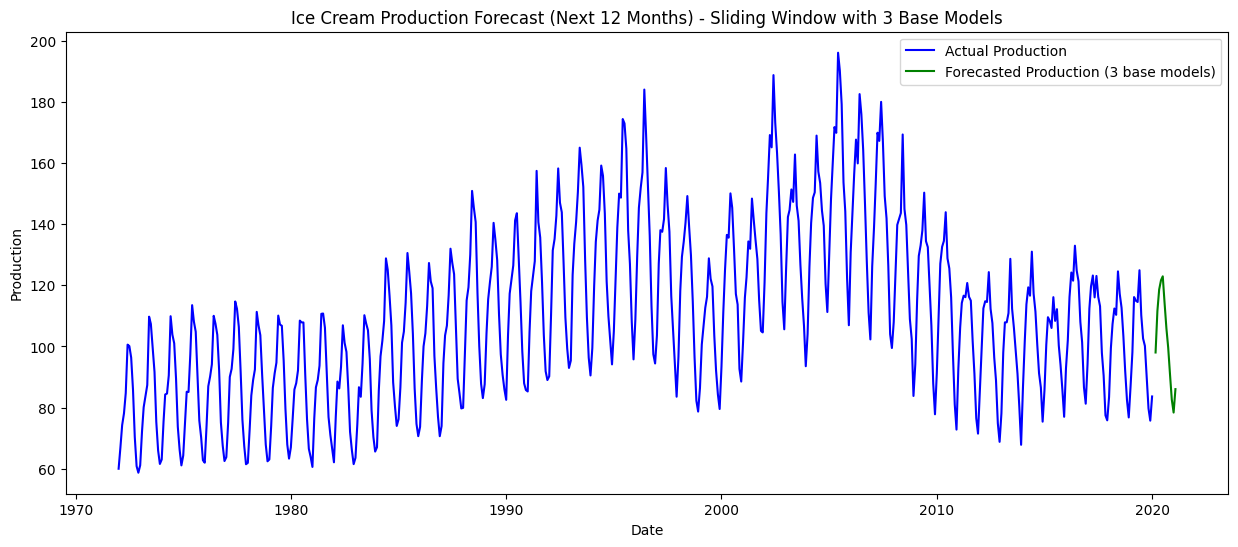

RMSE: 6.196240727928091
MSE: 38.39339915843484
MAE: 5.089241808279032
R^2 Score: 0.8493111713673671


In [ ]:
# Plotting the actual vs predicted values with the sliding window approach (3 base models)
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['IPN31152N'], label='Actual Production', color='blue')
plt.plot(pd.date_range(start=df.index[-1], periods=13, freq='ME')[1:], predictions_voting, label='Forecasted Production (3 base models)', color='green')
plt.title('Ice Cream Production Forecast (Next 12 Months) - Sliding Window with 3 Base Models')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

# rmse_voting, mse_voting, mae_voting, r2_voting, predictions_voting
print("RMSE:", rmse_voting)
print("MSE:", mse_voting)
print("MAE:", mae_voting)
print("R^2 Score:", r2_voting)

In [ ]:
# Ambil tanggal terakhir dari index 'DATE'
last_date = df.index[-1]  # Ini ambil tanggal dari index

# Buat list tanggal untuk 12 bulan ke depan
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')  # 'MS' = Mulai dari awal bulan

# Membuat DataFrame untuk hasil prediksi dengan tanggal
df_predictions = pd.DataFrame({
    'Date': future_dates,
    'Predicted Value': predictions_voting
})

# Menampilkan DataFrame prediksi dengan tanggal
df_predictions


,Date,Predicted Value
0,2020-02-01,98.022136
1,2020-03-01,111.621013
2,2020-04-01,118.646867
3,2020-05-01,121.675161
4,2020-06-01,122.966134
5,2020-07-01,114.166667
6,2020-08-01,105.908311
7,2020-09-01,99.619897
8,2020-10-01,90.810461
9,2020-11-01,82.629228


#### Arima

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


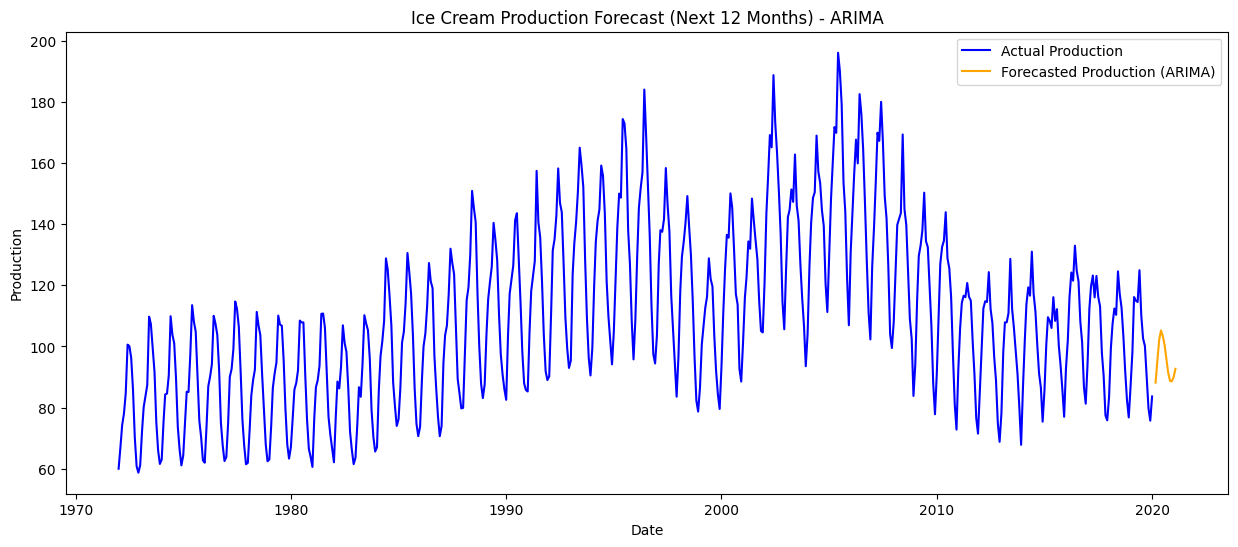

ARIMA Metrics:
RMSE: 12.333444832552512
MSE: 152.11386143761626
MAE: 11.09693695593728
R^2 Score: 0.3462485919636229


In [ ]:
# Fit ARIMA model
model_arima = ARIMA(df['IPN31152N'], order=(5, 1, 0))  # Sesuaikan order (p, d, q)
model_arima_fit = model_arima.fit()

# Forecast untuk 12 bulan ke depan
forecast_arima = model_arima_fit.forecast(steps=12)

# Hitung metrik untuk ARIMA
y_test_arima = df['IPN31152N'].values[-12:]  # Ambil data aktual untuk 12 bulan terakhir
rmse_arima = np.sqrt(mean_squared_error(y_test_arima, forecast_arima))
mse_arima = mean_squared_error(y_test_arima, forecast_arima)
mae_arima = mean_absolute_error(y_test_arima, forecast_arima)
r2_arima = r2_score(y_test_arima, forecast_arima)

# Plotting hasil prediksi ARIMA
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['IPN31152N'], label='Actual Production', color='blue')
plt.plot(pd.date_range(start=df.index[-1], periods=13, freq='ME')[1:], forecast_arima, label='Forecasted Production (ARIMA)', color='orange')
plt.title('Ice Cream Production Forecast (Next 12 Months) - ARIMA')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

# Print metrik ARIMA
print("ARIMA Metrics:")
print("RMSE:", rmse_arima)
print("MSE:", mse_arima)
print("MAE:", mae_arima)
print("R^2 Score:", r2_arima)


#### Linier Regression

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


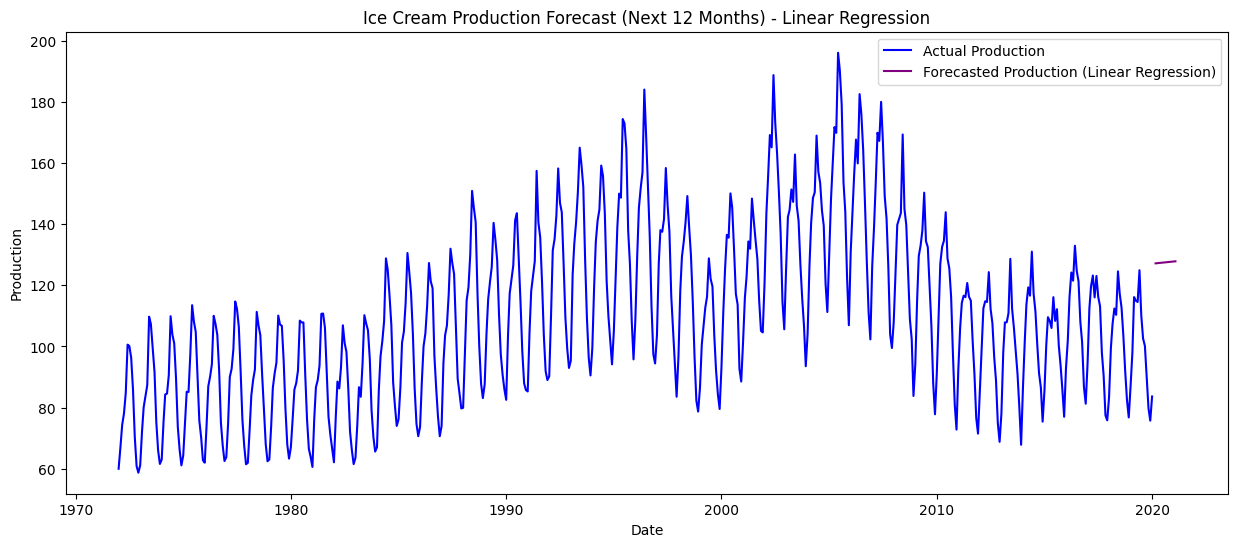

Linear Regression Metrics:
RMSE: 30.76593791572399
MSE: 946.5429358341829
MAE: 26.62520963498095
R^2 Score: -3.0680301664832967


In [ ]:
# Membuat fitur bulan dari data
df['Month_Num'] = range(1, len(df) + 1)

# Fit Linear Regression model
lin_reg_model = LinearRegression()
lin_reg_model.fit(df[['Month_Num']], df['IPN31152N'])

# Prediksi 12 bulan ke depan
future_months = np.array(range(len(df) + 1, len(df) + 13)).reshape(-1, 1)
forecast_lin_reg = lin_reg_model.predict(future_months)

# Hitung metrik untuk Linear Regression
y_test_lin_reg = df['IPN31152N'].values[-12:]  # Ambil data aktual untuk 12 bulan terakhir
rmse_lin_reg = np.sqrt(mean_squared_error(y_test_lin_reg, forecast_lin_reg))
mse_lin_reg = mean_squared_error(y_test_lin_reg, forecast_lin_reg)
mae_lin_reg = mean_absolute_error(y_test_lin_reg, forecast_lin_reg)
r2_lin_reg = r2_score(y_test_lin_reg, forecast_lin_reg)

# Plotting hasil prediksi Linear Regression
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['IPN31152N'], label='Actual Production', color='blue')
plt.plot(pd.date_range(start=df.index[-1], periods=13, freq='ME')[1:], forecast_lin_reg, label='Forecasted Production (Linear Regression)', color='purple')
plt.title('Ice Cream Production Forecast (Next 12 Months) - Linear Regression')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

# Print metrik Linear Regression
print("Linear Regression Metrics:")
print("RMSE:", rmse_lin_reg)
print("MSE:", mse_lin_reg)
print("MAE:", mae_lin_reg)
print("R^2 Score:", r2_lin_reg)


### Kesimpulan

model dengan metode bagging regressor adalah model yang terbaik dengan perbandingan rmse lebih kecil dari model arima dan regresi linier